In [1]:
%pylab inline
import wrf
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:

d = Dataset(f'/WRF/test/em_scm_xy/wrfout_d01')
#print(d.variables.keys())

In [3]:
theta = wrf.getvar(d, 'theta', timeidx=wrf.ALL_TIMES)
qvapor = wrf.getvar(d, 'QVAPOR', timeidx=wrf.ALL_TIMES)
height = wrf.getvar(d, 'height', timeidx=wrf.ALL_TIMES)
u, v = wrf.getvar(d, 'uvmet', timeidx=wrf.ALL_TIMES)
pbl_theta = wrf.getvar(d, 'RTHBLTEN', timeidx=wrf.ALL_TIMES)
v = wrf.getvar(d, 'v', timeidx=wrf.ALL_TIMES)

ci = wrf.getvar(d, 'cape_2d', timeidx=wrf.ALL_TIMES)

#print(theta.shape)
#print(height)
print(height[:,:,0,0].T.shape, theta[:,:,0,0].T.shape)

(59, 60) (59, 60)


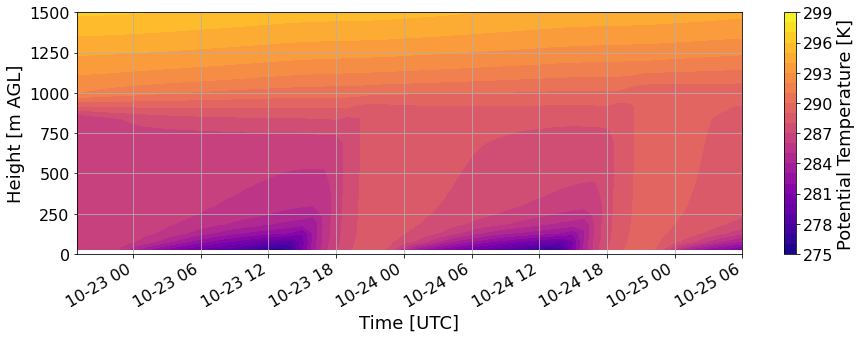

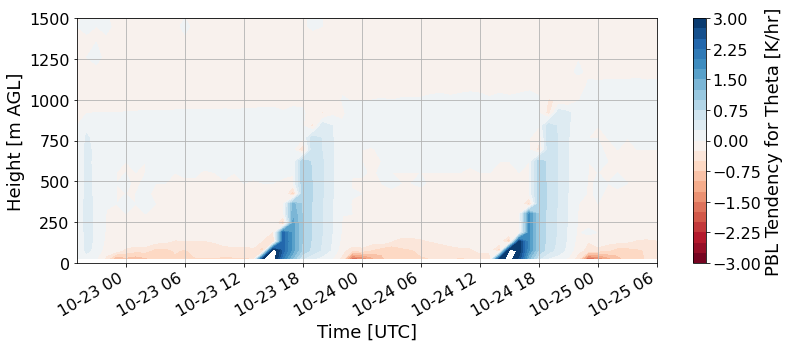

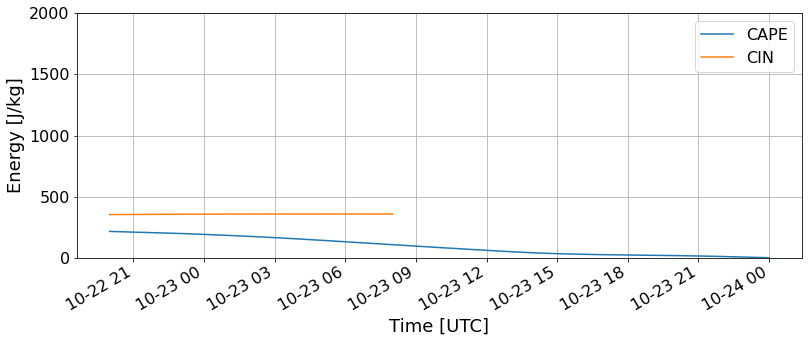

In [7]:
fig = figure(figsize=(13,5), facecolor='w')
#title(f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
c = contourf(theta.Time, height[0,:,0,0].T, theta[:,:,0,0].T, np.arange(275,300,1), cmap='plasma')
wspd = np.sqrt(np.power(u[:,:,0,0].T, 2) + np.power(v[:,:,0,0].T, 2))
#barbs(theta.Time, height[0,:,0,0], u[:,:,0,0].T, v[:,:,0,0].T, wspd, cmap='Greys', length=4)
cb = colorbar(c)
cb.ax.set_ylabel("Potential Temperature [K]")
ylim(0,1500)
ylabel("Height [m AGL]")
xlabel("Time [UTC]")
grid()
fig.autofmt_xdate()
plt.tight_layout()
savefig("example.png", bbox_inches='tight')
show()

fig = figure(figsize=(13,5))
#title(f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
c = contourf(theta.Time, height[0,:,0,0].T, 3600*pbl_theta[:,:,0,0].T, np.arange(-3,3.25,.25), cmap='RdBu')
wspd = np.sqrt(np.power(u[:,:,0,0].T, 2) + np.power(v[:,:,0,0].T, 2))
#barbs(theta.Time, height[0,:,0,0], u[:,:,0,0].T, v[:,:,0,0].T, wspd, cmap='Greys', length=4)
cb = colorbar(c)
cb.ax.set_ylabel("PBL Tendency for Theta [K/hr]")
ylim(0,1500)
ylabel("Height [m AGL]")
xlabel("Time [UTC]")
grid()
fig.autofmt_xdate()

show()


fig = figure(figsize=(13,5))
plot(theta.Time, ci[0,:,0,0], label='CAPE')
plot(theta.Time, ci[1,:,0,0], label='CIN')
legend(loc=0)
grid()
ylim(0,2000)
fig.autofmt_xdate()
xlabel("Time [UTC]")
ylabel("Energy [J/kg]")
show()

In [65]:
d.BL_PBL_PHYSICS

5

In [ ]:

fig = figure(figsize=(13,5))
title(f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
c = contourf(theta.Time, height[0,:,0,0].T, 1000*qvapor[:,:,0,0].T, np.arange(0,6.25,.25), cmap='gist_earth_r')
wspd = np.sqrt(np.power(u[:,:,0,0].T, 2) + np.power(v[:,:,0,0].T, 2))
#barbs(theta.Time, height[0,:,0,0], u[:,:,0,0].T, v[:,:,0,0].T, wspd, cmap='Greys', length=4)
cb = colorbar(c)
cb.ax.set_ylabel("Water Vapor Mixing Ratio [g/kg]")
ylim(0,1500)
ylabel("Height [m AGL]")
xlabel("Time [UTC]")
grid()
fig.autofmt_xdate()
show()